In [3]:
%load_ext cython

In [4]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd
import math, random

import cython

@cython.boundscheck(False)
@cython.wraparound(False)

#distance square
cdef dist_sq_c(a, b):
    return np.sum((a-b)**2)


#minimum distance square for every point to the centroid
cdef point_sq_c(data,centroid):
    dist=[min(dist_sq_c(d,c) for c in centroid) for d in data]
    return dist
        

#calculate probability
cdef dist_prob_parallel_c(Dist,l):
    return l*Dist/np.sum(Dist)


#step 2: calculate the cost and number of iterations(log(cost))
cdef log_cost_c(data_copy,centroid):
    cost=np.sum(point_sq_c(data_copy,centroid))
    iteration=math.ceil(np.log(cost))
    return iteration

    
    
#calculate weights
#step 4: assign the weights
#calculate weights
#step 4: assign the weights
cdef weight_prob_c(data_copy, centroid):
    weight=[np.argmin(list(dist_sq_c(d,c) for c in centroid)) for d in data_copy]
    w=np.array([weight.count(i) for i in range(len(data_copy))])
    return w



#step 5: recluster the weighted points in C into k clusters
#reinitialize k centroids
cdef reassign_centroids_c(centroid,k,d,w):
    new_centroid=np.zeros([k,d])
    for cluster in range(k):
        #according to the weights from step 4, calculate the probability that a point is sampled from C
        prob_w=list(w/sum(w))
        #sample a new centroid
        new_index=np.random.choice(centroid.shape[0],1,prob_w)
        #store the new centroid
        new_centroid[cluster]=centroid[new_index]
        #delete the new centroid from the centroid
        centroid=np.delete(centroid,new_index,axis=0)
        #delete the correponding weight
        w=np.delete(w,new_index,axis=0)
    return new_centroid



def kmeansparallel_c(data, k, l, d, r):
    #step 1: sample a point uniformly at random from X
    random.seed(22)
    index=int(np.random.choice(data.shape[0],1))
    centroid=np.array(data[index])
    data_copy=data.copy()
    data_copy=np.delete(data_copy,index,axis=0)
    
    #step 2: calculate number of iteration
    iteration= log_cost_c(data_copy,centroid)
    
    #step 3: Get initial Centroids C
    for round in range(r):
        for number in range(iteration):
        #calculate phi_X(C)
            distance=point_sq_c(data_copy,centroid)
        #calculate the probability
            prob=dist_prob_parallel_c(distance,l).tolist()
            for n in range(data_copy.shape[0]):
            #if the probability is greater than the random uniform
                if prob[n]>np.random.uniform():
                #add the point to C
                    centroid=np.vstack([centroid,np.array(data_copy[n])])
                #delete that point from the copy
                    data_copy=np.delete(data_copy,n,axis=0)
    
    #step 4: calculate the weight probability
    w=weight_prob_c(data_copy,centroid)
    
    #step 5: recluster the weighted points in C into k clusters
    #reinitialize k centroids
    new_centroids=reassign_centroids_c(centroid,k,d,w)
    
    return new_centroids

    
#with the initialization of the centroids from the function kmeansplusplus
#plug in the original data(dataSet), initializtions(initial) and the dimension of the data(d)
def kmeans_c(dataSet, initial, k, d):
    random.seed(22)
    centroids=initial
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.zeros(initial.shape)
    
    # Run the main k-means algorithm
    while not shouldStop_c(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        l= getLabels(dataSet, centroids)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids_c(dataSet, l, k, d)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids, np.array(l)
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
cdef shouldStop_c(oldCentroids, centroids, iterations):
    if iterations > 50: return True
    return oldCentroids.all == centroids.all
# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
cdef getLabels(dataSet, centroids):
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.
    
    l=[np.argmin(list(dist_sq_c(d,c) for c in centroids)) for d in dataSet]
    return l
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
cdef getCentroids_c(dataSet, labels, k, d):
    # Each centroid is the arithmetic mean of the points that
    # have that centroid's label.
    data_new = pd.DataFrame(dataSet.copy())
    data_new['Labels'] = labels
    data_new = np.array(data_new.groupby(['Labels']).mean().iloc[:,:d])
  
    return data_new

In [5]:
import simulatedData
from simulatedData import generate_data

In [40]:
random.seed(22)
sim_data_k6 = generate_data(k=6, var=100, dim=2, npoints=10000)
k = 6
l=k*2
d = 2
r = 1

In [43]:
c_cython=kmeansparallel_c(sim_data_k6, k, l, d, r)

In [44]:
c_kmeans_cython=kmeans_c(sim_data_k6,c_cython,k,d)

In [45]:
x_cython = c_kmeans_cython[0][:,0]
y_cython = c_kmeans_cython[0][:,1]
labels_cython = c_kmeans_cython[1]

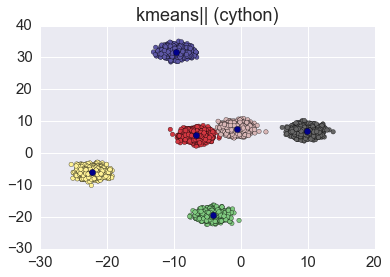

In [46]:
plt.figure()
plt.scatter(sim_data_k6[:,0], sim_data_k6[:,1], c=labels_cython, cmap='Accent')
plt.scatter(x_cython, y_cython, s=40, marker="o", c="darkblue")
plt.title("kmeans|| (cython)")
pass

In [17]:
sim_data= generate_data(k=6, var=100, dim=15, npoints=10000)

In [18]:
# set parameters
k = 6
l=k*2
d = 15
r = 1

In [19]:
%timeit kmeans_c(sim_data, kmeansparallel_c(sim_data, k, l, d, r), k, d)

1 loop, best of 3: 53.7 s per loop


In [20]:
import kmeans_combined_revised
from kmeans_combined_revised import kmeansparallel, kmeans

In [21]:
%timeit kmeans(sim_data, kmeansparallel(sim_data, k, l, d, r), k, d)

1 loop, best of 3: 58.4 s per loop
